# Week 04:

This notebook follows some of the examples in *Visualization in Bayesian Workflow* by Gabry, Simpson, Vehtari, Betancourt, and Gelman.

Our goal for this problem is to estimate ground-station values of $PM_{2.5}$ (air concentrations of particulate matter of 2.5 microns or below), with uncertainty intervals, from satellite data. That is, we want to use a high-quality, reliable dataset that suffers from sparse and biased collection to calibrate a noisier dataset that we can collect anywhere. The plan:

1. Do some exploratory data analysis
* Formulate a model
* Evaluate how we've specified the model, before running inference, using samples from the prior predictive distribution
* Run inference and inspect the MCMC results visually
* Evaluate the model's performance using samples from the posterior predictive distribution
* Define a more-complicated model and use these tools to compare them

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pystan
from scipy.stats import linregress, skew

%matplotlib inline
from IPython.core.pylabtools import figsize

## Load the data

In [2]:
data = pd.read_csv("../data/particulate_data.csv", encoding="iso-8859-1")
len(data)

2980

In [3]:
data.head()

,City_locality,iso3,country,super_region,super_region_name,pm25,sat_2014,log_pm25,log_sat,cluster_region
0,NaN,AUS,Australia,1,HighIncome,33.463801,33.314292,3.510464,3.505986,2
1,´è_´è__lhavo,PRT,Portugal,1,HighIncome,15.000000,9.867000,2.708050,2.289196,2
2,´è_´è__vila,ESP,Spain,1,HighIncome,10.000000,9.175500,2.302585,2.216537,2
3,AACHEN,DEU,Germany,1,HighIncome,13.000000,15.537997,2.564949,2.743288,2
4,AALBORG,DNK,Denmark,1,HighIncome,11.000000,9.798502,2.397895,2.282230,2


## Exploratory data analysis

Since we're relating two variables, expect a lot of scatter plots.

Start with the logarithm of the ground-station measurements, plotted against the logarithm of the satellite measurements:

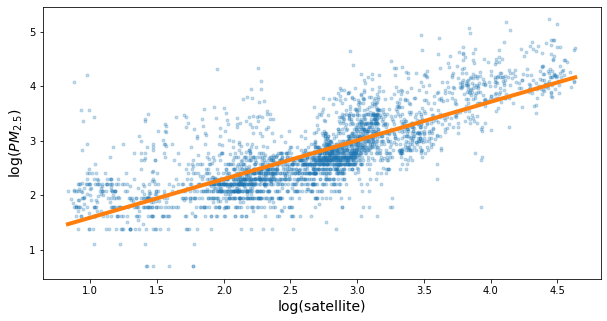

In [4]:
figsize(10,5)
slope, intercept, *_ = linregress(data.log_sat, data.log_pm25)
full_x = np.array([data.log_sat.min(), data.log_sat.max()])
full_y = slope*full_x+intercept

plt.plot(data.log_sat, data.log_pm25, ".", alpha=0.25)
plt.plot(full_x, full_y, lw=4)

plt.xlabel("log(satellite)", fontsize=14)
plt.ylabel("log($PM_{2.5}$)", fontsize=14);

If you squint, the linear regression line seems like an OK(ish) place to start; the data definitely has an overall linear correlation. The focus of the rest of this notebook will be on the extent to which deviations from this linear relationship are going to mess us up.

If we look closer, however, the errors don't seem to be totally random (e.g. they're not I.I.D. normal)- the data seems to have some structure to it, with some areas tending to have positive residuals and other areas negative. Let's do some more exploration to see if we can (qualitatively) understand where this is coming from.

One possibility is that different *types* of locations have different relationships between satellite and ground station data. We could do a quick check by breaking out the above plot by WHO super-regions:

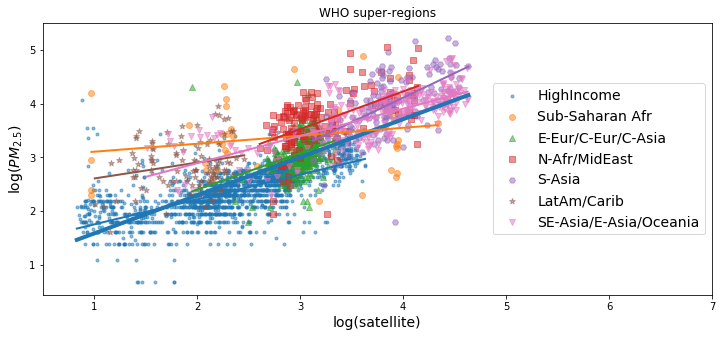

In [5]:
figsize(12,5)
plt.plot(full_x, full_y, lw=4)

markers = [".", "o", "^", "s", "H", "*", "v"]
colors = list(matplotlib.colors.TABLEAU_COLORS)#[:7]
for i, m, c in zip(data.super_region_name.unique(), markers, colors):
    subset = data[data.super_region_name == i]
    plt.scatter(subset.log_sat, subset.log_pm25, marker=m, color=c, alpha=0.5, label=i)
    
    slope, intercept, *_ = linregress(subset.log_sat, subset.log_pm25)
    x = np.array([subset.log_sat.min(), subset.log_sat.max()])
    plt.plot(x, slope*x+intercept, c, lw=2)
    
plt.legend(loc="center right", fontsize=14)
plt.xlabel("log(satellite)", fontsize=14)
plt.ylabel("log($PM_{2.5}$)", fontsize=14)
plt.title("WHO super-regions")
plt.xlim(0.5, 7);

Notice that the different geographic areas only partially overlap, and regression lines fit to each show very different relationships. Gabry *et al* also tried grouping stations using hierarchical clustering (labeled "cluster_region" in the dataset):

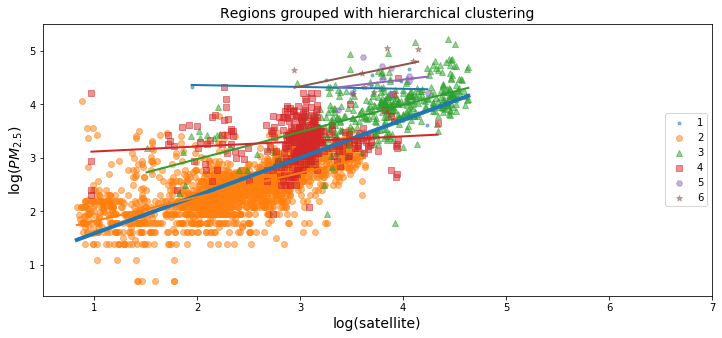

In [6]:
figsize(12,5)
plt.plot(full_x, full_y, lw=4)

for i, m, c in zip(range(1,7), markers, colors):
    subset = data[data.cluster_region == i]
    plt.scatter(subset.log_sat, subset.log_pm25, marker=m, color=c, alpha=0.5, label=i)
    
    slope, intercept, *_ = linregress(subset.log_sat, subset.log_pm25)
    x = np.array([subset.log_sat.min(), subset.log_sat.max()])
    plt.plot(x, slope*x+intercept, c, lw=2)
    
plt.legend(loc="center right")
plt.title("Regions grouped with hierarchical clustering", fontsize=14)
plt.xlabel("log(satellite)", fontsize=14)
plt.ylabel("log($PM_{2.5}$)", fontsize=14)
plt.xlim(0.5, 7);

Just as in the super-region plot, we see very different dependences here. When we start modeling, we'll need to be on the lookout for biases in predictions on different types of locations.

## Baseline model

To have something to benchmark against, let's start by fitting a Bayesian linear regression,

$y_{i} \sim N(\beta_{0} + \beta_{1}x_{i}, \sigma^{2})$

where $y_{i}$ is the ground station $PM_{2.5}$ measurement, $x_{i}$ is this satellite measurement, and $\beta_{0}$, $\beta_{1}$, and $\sigma$ are the parameters we need to infer. We'll use a normal distribution for priors on $\beta_{0}$ and $\beta_{1}$, and a half-normal for $\sigma$ (since it has to be positive).

Before fitting anything, we should do a "keep yourself honest" check to see how well we've specified our model. Even without touching stan, it's easy to draw fake data from the prior predictive distribution:

1. draw samples $\beta_{0}^{'}$, $\beta_{1}^{'}$, and $\sigma^{'}$ for each of the parameters from their prior distribution
* for each data point $x$, compute an estimate $y^{'} = \beta_{0}^{'} + \beta_{1}^{'}x + \epsilon\sigma^{'})$, where $\epsilon \sim N(0,1)$

Let's plot some of our prior predictive datasets alongside our actual data, starting with "weakly informative" priors:

In [7]:
# simple linear model
f = open('../stan/particulate_matter_ols_prior_weak.stan', 'r')
file_contents = f.read()
print (file_contents)
f.close()

// ols model for particulate matter
// generate from the prior
data {
  int<lower=1> N;       // number of observations
  vector[N] log_sat;    // log of satellite measurements
}
parameters {
  real beta0;           // global intercept
  real beta1;           // global slope
  real<lower=0> sigma;  // error sd for Gaussian likelihood
}
model {
  // priors
  beta0 ~ normal(0, 100);
  beta1 ~ normal(0, 100);
  sigma ~ normal(0, 100);
}
generated quantities {
  vector[N] log_pm_prior; // vector of data generated from prior

  for (i in 1:N) {
      log_pm_prior[i] = normal_rng(beta0 + beta1 * log_sat[i],sigma);
  }
}



In [8]:
prior_model = pystan.StanModel(file='../stan/particulate_matter_ols_prior_weak.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_901e9085c7cc55171c9b358c81cb080e NOW.


In [9]:
datadict = {"N":len(data), "log_sat":data.log_sat.values}

In [10]:
prior_samples = prior_model.sampling(data=datadict, iter=100, chains=1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [11]:
log_pm_prior = prior_samples.extract()["log_pm_prior"]

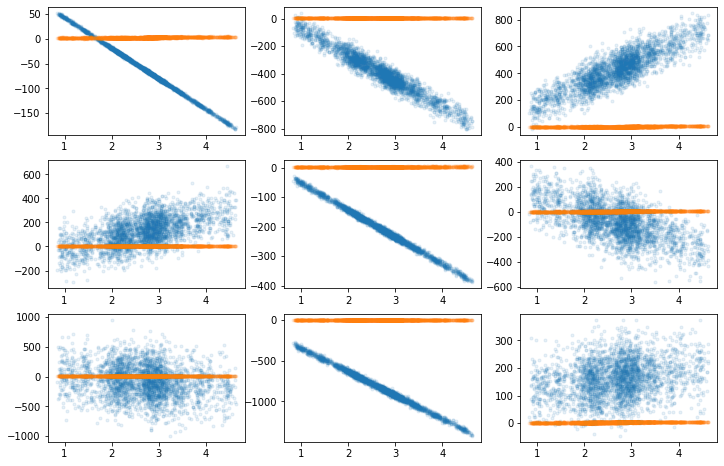

In [12]:
figsize(12, 8)
N = len(data)

num_graphs = 9
idx = np.random.choice(np.arange(len(log_pm_prior)),size=num_graphs,replace=False)

for i in range(num_graphs):
    plt.subplot(3,3,i+1)
    plt.plot(data.log_sat, log_pm_prior[idx[i],:], ".", alpha=0.1)
    plt.plot(data.log_sat, data.log_pm25, ".", alpha=0.1);

Some of these simulations include predictions orders of magnitude away from what we actually observe (remember we're working on log scales here!)! In some cases the slope also goes the wrong way- these priors generate data that's decidedly unphysical. This is bad for two reasons:

* It means the prior doesn't *really* represent our prior knowledge, which defeats the entire conceptual point of this branch of statistics
* More practically, it means that the data has to do more "work" than it should to constrain the prior. We'll tend to get posteriors that overestimate uncertainty and (if we do a *really* bad job specifying the prior) may be biased.

So what should we be looking for? From Gabry *et al*,

> What do we need in our priors? This suggests we need *containment*: priors that keep us inside sensible parts of the parameter space.

So our priors should be broader than (and include) our data- but not be so broad that they make impossible predictions. Let's try again with our intercept constrained to be near zero, slope biased toward being a small poisitive number (since we already know the measurements are roughly correlated) and noise confined to near the unit scale:

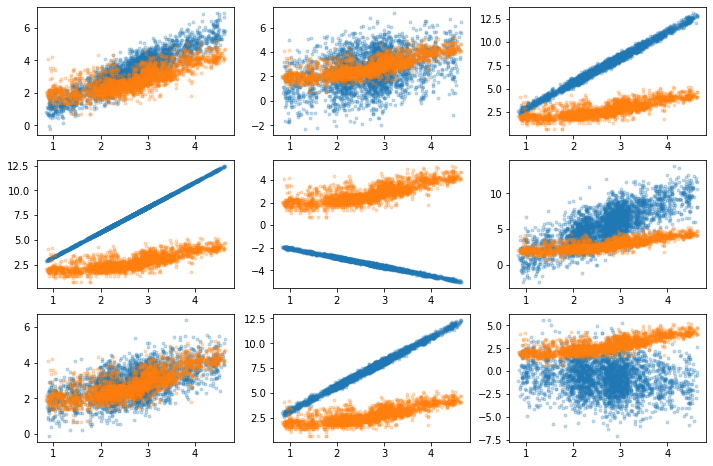

In [13]:
figsize(12, 8)
N = len(data)

for i in range(9):
    plt.subplot(3,3,i+1)
    sigma = np.abs(np.random.normal(0,1))

    beta0 = np.random.normal(0, 1)
    beta1 = np.random.normal(1, 1)
    eps = np.random.normal(0, sigma, size=N)
    y_sim = beta0 + beta1*data.log_sat.values + eps

    plt.plot(data.log_sat, y_sim, ".", alpha=0.25)
    plt.plot(data.log_sat, data.log_pm25, ".", alpha=0.25);

## Finally, some actual inference

Here's Gabry *et al's* code for the basic regression model:

In [14]:
# simple linear model
f = open('../stan/particulate_matter_ols.stan', 'r')
file_contents = f.read()
print (file_contents)
f.close()

// ols model for particulate matter
data {
  int<lower=1> N;       // number of observations
  vector[N] log_sat;    // log of satellite measurements
  vector[N] log_pm;     // log of ground PM_2.5 measurements
}
parameters {
  real beta0;           // global intercept
  real beta1;           // global slope
  real<lower=0> sigma;  // error sd for Gaussian likelihood
}
model {
  // priors
  beta0 ~ normal(0,1);
  beta1 ~ normal(1,1);
  sigma ~ normal(0,1);

  // likelihood
  log_pm ~ normal(beta0 + beta1 * log_sat, sigma);
}
generated quantities {
  vector[N] log_lik;    // pointwise log-likelihood for LOO
  vector[N] log_pm_rep; // replications from posterior predictive dist

  for (n in 1:N) {
    real log_pm_hat_n = beta0 + beta1 * log_sat[n];
    log_lik[n] = normal_lpdf(log_pm[n] | log_pm_hat_n, sigma);
    log_pm_rep[n] = normal_rng(log_pm_hat_n, sigma);
  }
}



Compile the model and run inference:

In [15]:
model = pystan.StanModel(file='../stan/particulate_matter_ols.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3edafe9cffa9b26b1538ab13b3ccd623 NOW.


In [16]:
datadict = {"N":len(data), "log_sat":data.log_sat.values, "log_pm":data.log_pm25.values}

In [17]:
fit = model.sampling(data=datadict, iter=10000, chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Extract traces of our parameters:

In [18]:
beta0_samples = fit.extract()["beta0"]
beta1_samples = fit.extract()["beta1"]
sigma_samples = fit.extract()["sigma"]
log_pm_rep = fit.extract()["log_pm_rep"]

In [19]:
log_pm_rep.shape

(20000, 2980)

### Trace plots

Gabry's paper has some slick visualizations for investigating your MCMC run, that we'll talk about in the future when we discuss Hamiltonian Monte Carlo. For now, just do some quick trace plots to ensure nothing terrible happened:

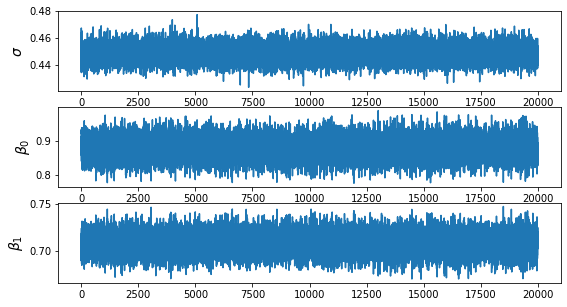

In [20]:
figsize(9,5)
plt.subplot(3,1,1)
plt.plot(sigma_samples)
plt.ylabel("$\\sigma$", fontsize=14)
plt.subplot(3,1,2)
plt.plot(beta0_samples)
plt.ylabel("$\\beta_{0}$", fontsize=14)
plt.subplot(3,1,3)
plt.plot(beta1_samples)
plt.ylabel("$\\beta_{1}$", fontsize=14);

Looks like we're mixing OK.

Not surprisingly, the slope and intercept show some negative correlation:

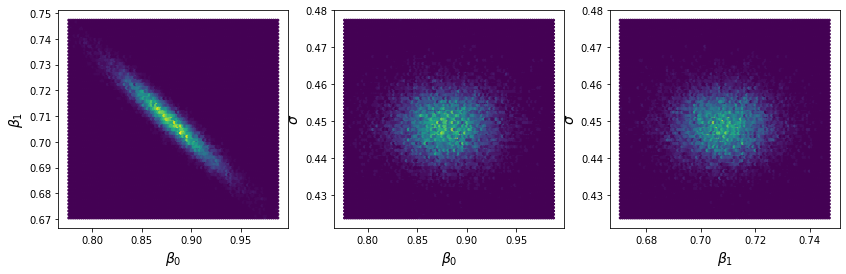

In [21]:
figsize(14,4)
plt.subplot(131)
plt.hexbin(beta0_samples, beta1_samples)
plt.ylabel("$\\beta_{1}$", fontsize=14)
plt.xlabel("$\\beta_{0}$", fontsize=14)

plt.subplot(132)
plt.hexbin(beta0_samples, sigma_samples)
plt.ylabel("$\\sigma$", fontsize=14)
plt.xlabel("$\\beta_{0}$", fontsize=14)

plt.subplot(133)
plt.hexbin(beta1_samples, sigma_samples)
plt.ylabel("$\\sigma$", fontsize=14)
plt.xlabel("$\\beta_{1}$", fontsize=14);

## Posterior Predictive Checks

Now that we've fit a model, we can draw data from the posterior predictive distribution $p(y^{'}|y)$. We can do a couple types of things with this fake data to get some intuition for how our model is doing:

* Directly compare samples from the PPD with real data
* Compute summary statistics on the PPD; compare range of values to the same statistic on the observed dataset.

In either case we can break those checks out by subsets of the data (like WHO super region) to see if the model describes data equally well in different regions, or whether we'll tend to see geographic biases in any estimates we make from the model.

### Direct comparisons

Here's a flipbook of scatter plots, comparing PPD datasets with the real:

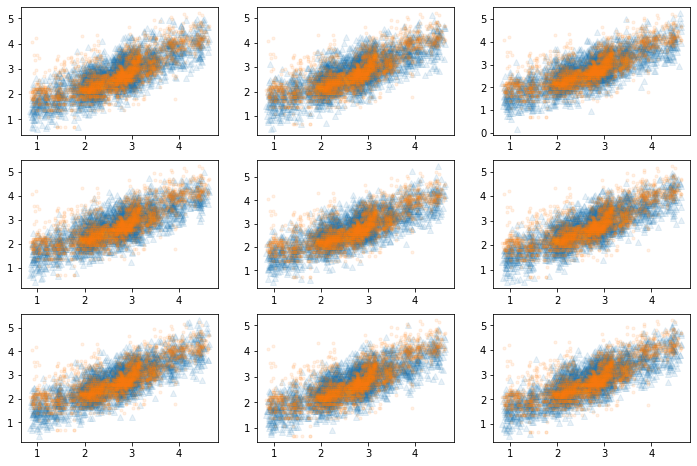

In [22]:
figsize(12,8)
for i in range(9):
    plt.subplot(3,3,i+1)
    index = np.random.randint(log_pm_rep.shape[0])
    plt.plot(data.log_sat, log_pm_rep[index,:], "^", alpha=0.1)
    plt.plot(data.log_sat, data.log_pm25, ".", alpha=0.1);

While they certainly overlap, (as expected) there's some interesting structure in the real data that the PPD doesn't capture. Breaking out by super region exacerbates the differences:

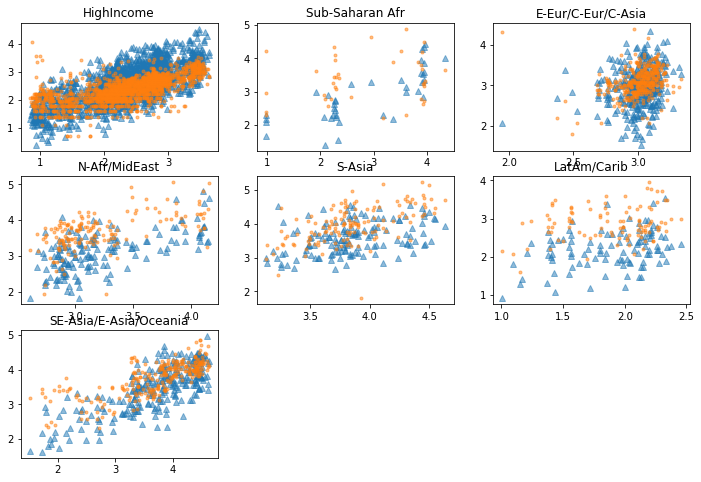

In [23]:
figsize(12,8)
j = 1
for i in data.super_region_name.unique():
    plt.subplot(3,3,j)
    subset = data[data.super_region_name == i]
    ppc_subset = log_pm_rep[:,data.super_region_name.values == i]
    
    plt.plot(subset.log_sat, log_pm_rep[0,data.super_region_name.values == i], "^", alpha=0.5)
    plt.plot(subset.log_sat, subset.log_pm25, ".", alpha=0.5)
    plt.title(i)
    j += 1

If we compare the histogram of observed $PM_{2.5}$ values with samples from the PPD:

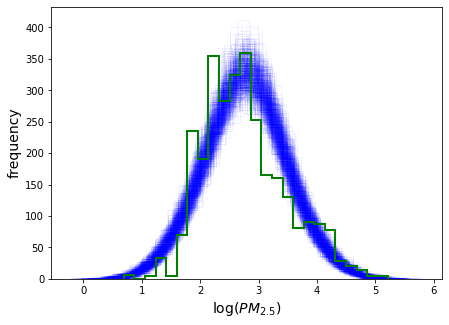

In [24]:
figsize(7,5)
for i in range(500):
    plt.hist(log_pm_rep[i,:], histtype="step", color="b", alpha=0.05, bins=25)
    
plt.hist(data.log_pm25.values, histtype="step", lw=2, color="g", bins=25)
plt.ylabel("frequency", fontsize=14)
plt.xlabel("log($PM_{2.5}$)", fontsize=14);

the real data has some asymmetry that the synthetic data is missing.

## Comparison with summary statistics

A danger with posterior predictive checking is that we're "double dipping" with our data- using it once to fit the model and a second time to check it. When we're comparing summary statistics, a poor choice of statistic could obscure a serious problem with the model.

Consider, for example, a model where one parameter controls the mean of the posterior distribution. Comparing means of samples from the PPD will probably look good (because that parameter can learn the mean of your data easily) even if the shape of the fit is terrible. It's good practice, then, to select test statistics that aren't directly related to a single model parameter.

In this case- since our histogram showed that the real data is much less symmetric than the posterior predictive distribution, let's use the skewness (a measure of distribution asymmetry):

In [25]:
observed_skew = skew(data.log_pm25.values)
ppc_skews = np.array([skew(log_pm_rep[i,:]) for i in range(log_pm_rep.shape[0])])

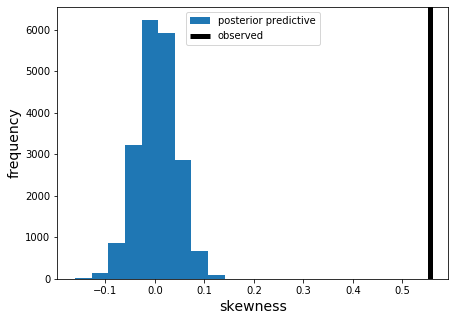

In [26]:
figsize(7,5)
plt.hist(ppc_skews, label="posterior predictive")
ylim = plt.ylim()
plt.vlines(observed_skew, -1e6, 1e6, lw=5, label="observed")
plt.ylim(ylim)
plt.xlabel("skewness", fontsize=14)
plt.ylabel("frequency", fontsize=14)
plt.legend(loc="upper center");

Breaking out a statistic (let's try median this time) by WHO super region, we'll see that not only do the samples not resemble the observed data, but they're wrong in different directions for different regions! If we were answering questions that compared estimates for different geographical regions, this would be a first step to getting really dumb answers.

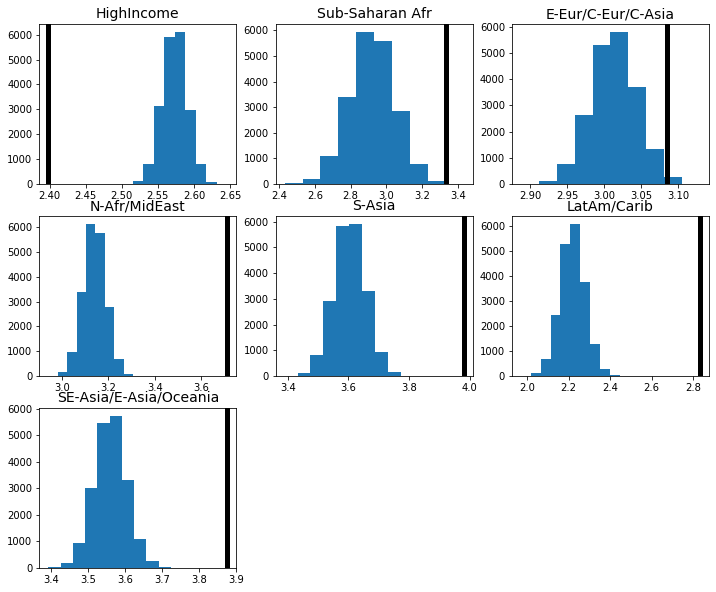

In [27]:
figsize(12,10)
j = 1
for i in data.super_region_name.unique():
    plt.subplot(3,3,j)
    subset = data[data.super_region_name == i]
    ppc_subset = log_pm_rep[:,data.super_region_name.values == i]
    submedian = np.array([np.median(ppc_subset[k,:]) for k in range(ppc_subset.shape[0])])
    
    plt.hist(submedian, label="posterior predictive")
    ylim = plt.ylim()
    plt.vlines(np.median(subset.log_pm25.values), -1e6, 1e6, lw=5, label="observed")
    plt.ylim(ylim)
    plt.title(i, fontsize=14)
    j += 1

# The undiscovered country

**What's next?** By this point we should all agree that this problem deserves a model more nuanced than simple linear regression. Build a better model and run some of the same tests to see how it performs!

* One option: run separate regressions for different regions or clusters

* Another option, in between "one big stupid regression" and "a ton of independent regressions": build a multilevel model that has separate parameters for each super region (or cluster), but treats those parameters as draws from a common distribution to be learned. This allows the different regions to use some information from each other while still preserving conditional independence. We'll do a *lot* more with multilevel models later!

Also: a multilevel model, ripped off from Gabry's Github:

In [28]:
# simple linear model
f = open('../stan/particulate_matter_multilevel.stan', 'r')
file_contents = f.read()
print (file_contents)
f.close()

// multilevel model for particulate matter
// assume non-centered data
data {
  int<lower=1> N;                   // number of observations
  int<lower=1> R;                   // number of super regions
  int<lower=1,upper=R> region[N];   // region IDs
  vector[N] log_sat;                // log of satellite measurements
  vector[N] log_pm;                 // log of ground PM_2.5 measurements
}
parameters {
  real beta0;                       // global intercept
  real beta1;                       // global slope
  vector[R] beta0_region_raw;       // 'raw' region intercept offsets for NCP
  vector[R] beta1_region_raw;       // 'raw' region slope offsets for NCP
  real<lower=0> tau0;               // sd of beta0_region
  real<lower=0> tau1;               // sd of beta1_region
  real<lower=0> sigma;              // error sd for Gaussian likelihood
}
model {
  // mean of likelihood
  vector[N] mu;

  // priors
  beta0 ~ normal(0,1);
  beta1 ~ normal(1,1);
  tau0 ~ normal(0,1);
  tau1 ~ no

# FOR THE LAB: delete everything below this cell

In [29]:
ml_model = pystan.StanModel(file='../stan/particulate_matter_multilevel.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c606b45953f6811dcc2d095a512bf1a3 NOW.


In [30]:
datadict = {"N":len(data), "log_sat":data.log_sat.values, "log_pm":data.log_pm25.values,
           "R":len(data.super_region_name.unique()), "region":data.super_region.values}

In [31]:
ml_fit = ml_model.sampling(data=datadict, iter=1000, chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [32]:
beta0_samples_ml = ml_fit.extract()["beta0"]
beta1_samples_ml = ml_fit.extract()["beta1"]
sigma_samples_ml = ml_fit.extract()["sigma"]
log_pm_rep_ml = ml_fit.extract()["log_pm_rep"]

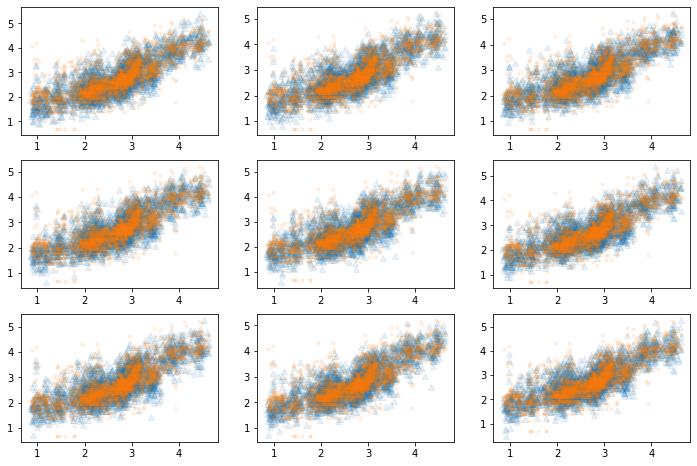

In [33]:
figsize(12,8)
for i in range(9):
    plt.subplot(3,3,i+1)
    index = np.random.randint(log_pm_rep_ml.shape[0])
    plt.plot(data.log_sat, log_pm_rep_ml[index,:], "^", alpha=0.1)
    plt.plot(data.log_sat, data.log_pm25, ".", alpha=0.1);

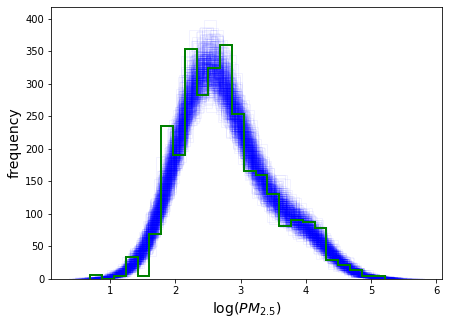

In [34]:
figsize(7,5)
for i in range(500):
    plt.hist(log_pm_rep_ml[i,:], histtype="step", color="b", alpha=0.05, bins=25)
    
plt.hist(data.log_pm25.values, histtype="step", lw=2, color="g", bins=25)
plt.ylabel("frequency", fontsize=14)
plt.xlabel("log($PM_{2.5}$)", fontsize=14);

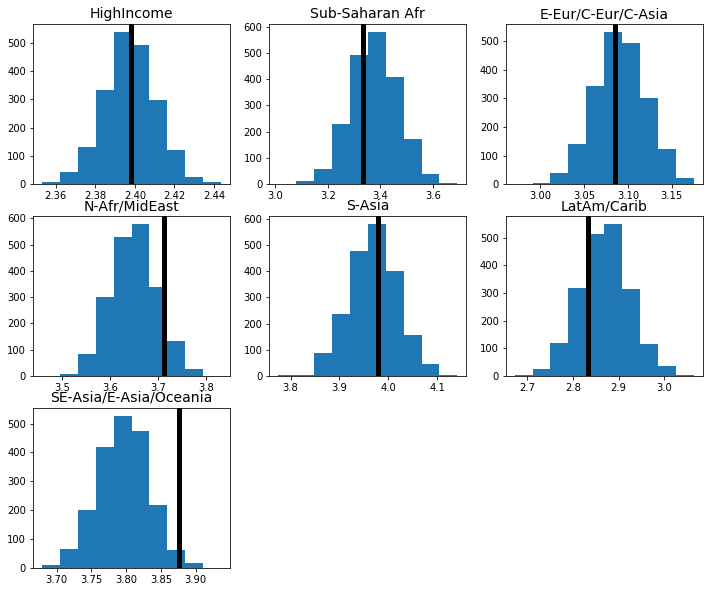

In [35]:
figsize(12,10)
j = 1
for i in data.super_region_name.unique():
    plt.subplot(3,3,j)
    subset = data[data.super_region_name == i]
    ppc_subset = log_pm_rep_ml[:,data.super_region_name.values == i]
    submedian = np.array([np.median(ppc_subset[k,:]) for k in range(ppc_subset.shape[0])])
    
    plt.hist(submedian, label="posterior predictive")
    ylim = plt.ylim()
    plt.vlines(np.median(subset.log_pm25.values), -1e6, 1e6, lw=5, label="observed")
    plt.ylim(ylim)
    plt.title(i, fontsize=14)
    j += 1